In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

#pysindy_path = r'C:\Users\phili\PycharmProjects\pysindy'

# Algebraic function with non unique polynomial PDE: $u(t,x)=\frac{1}{x+t}$
The function $u$ solves the equations $u_t = u_x$ and $u_t= -u^2$. We can now actually show that the Jacobi criterion for algbraic functions yields non-uniqueness.

In [20]:
x_0, x_end = 1, 5
t_0, t_end = 1, 5
nx, nt = (300, 200)
x = np.linspace(x_0, x_end, nx)
t = np.linspace(t_0, t_end, nt)
tv, xv = np.meshgrid(t, x)

u = 1/(xv + tv)

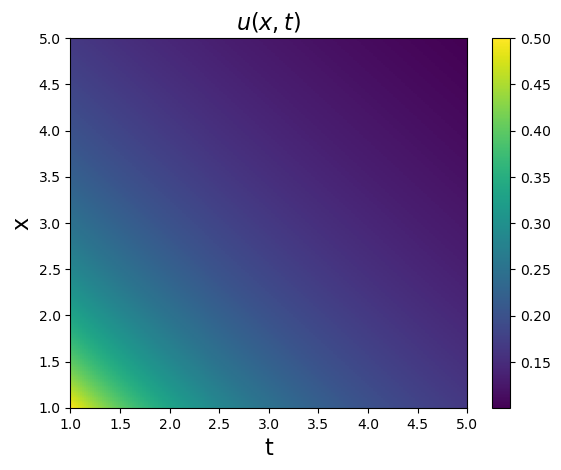

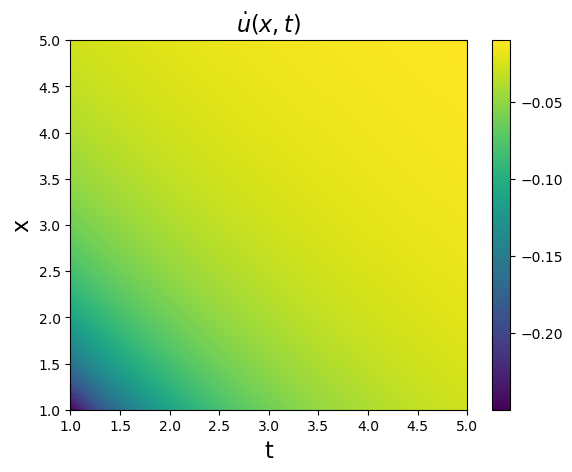

In [21]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

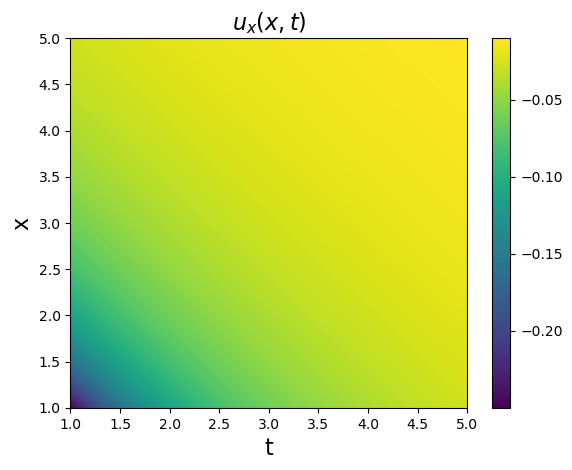

In [22]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)


# Plot derivative results
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.colorbar()
plt.show()

In [23]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.000
SR3 model, L0 norm: 
(x0)' = -1.000 x0x0
SR3 model, L1 norm: 


/home/groups/ai/hauger/miniconda3/envs/uniq/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (5) and eliminated all coefficients
  warnings.warn(


(x0)' = -1.000 x0x0
SSR model: 
(x0)' = -0.372 x0x0 + 0.628 x0_1
SSR (metric = model residual) model: 
(x0)' = -0.120 x0 + 1.845 x0x0_1
FROLs model: 
(x0)' = 0.000


So, we see that some models find the second equation, some find mixtures and some find none.
## Check now numerically if this is the unique equation

We already know that the equation is not unique. Assuming we know that the function is algebraic, we want to show the uniqueness now by applying the Jacobi criterion for algebraic functions.
### Jacobi criterion

In [24]:
from numpy.linalg import matrix_rank, svd

In [25]:
space_range = 28
time_range = 18
fd_orders = [2, 7]
sv_ratios = np.zeros([space_range, time_range])
svs = np.zeros([2, space_range, time_range])
for k, fd_order in enumerate(fd_orders):
    ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u, t=dt)
    utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
    uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u, dx) 
    space_range = 28
    time_range = 18
    for i in range(space_range):
        for j in range(time_range):
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
            sv = svd(jacobian, compute_uv=False)[-1]
            svs[k,i,j] = sv

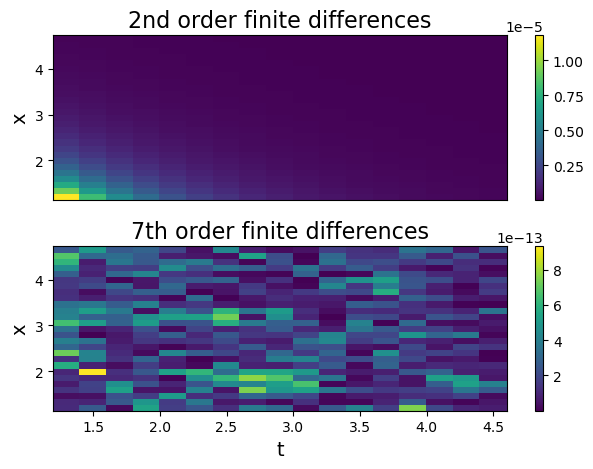

In [31]:
# Journal
titlesize = 18
subtitle_size = titlesize - 2
labelsize = titlesize - 2
tickssize = labelsize - 2
fontname="Times New Roman"
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / 200 * (t_end - t_0) + t_0, (np.arange(space_range) * 10 + 10) / 300 * (x_end - x_0) + x_0
# Plot derivative results
fig, axes = plt.subplots(2,1)
#plt.title(r'Smallest singular value of the Jacobian', fontsize=titlesize, fontname=fontname)
c = axes[0].pcolor(t_grid, x_grid, svs[0])
axes[0].set_title('2nd order finite differences', fontsize=subtitle_size, fontname=fontname)
axes[0].set_ylabel('x', fontsize=tickssize, fontname=fontname)
axes[0].set_xticks([])
fig.colorbar(c, ax=axes[0])
c = axes[1].pcolor(t_grid, x_grid, svs[1])
axes[1].set_title('7th order finite differences', fontsize=subtitle_size, fontname=fontname)
axes[1].set_xlabel('t', fontsize=tickssize, fontname=fontname)
axes[1].set_ylabel('x', fontsize=tickssize, fontname=fontname)
fig.colorbar(c, ax=axes[1])
plt.tight_layout()
#fig_path = r'D:\OneDrive\Dokumente\Uni\Doktor\Paper\Projects\Physical Law Learning\Images\Experiments\Uniqueness'
#plt.savefig(os.path.join(fig_path, 'Jacobi_polynomial_PDE_ambiguous_algebraic_function.eps'), format='eps')